In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
from vpython import *

In [36]:
data_path = r".\Data\1"
file_name=os.path.join(data_path, r"1_1.pcd")

def read_pcd(file_name):
    def float_2_rgb(num):
        packed = struct.pack('!f', num)
        return [c for c in packed][1:]

    pc = np.genfromtxt(file_name, skip_header =13)
    
    
    xyz=pc[:,0:3]
    rgb=np.asarray([float_2_rgb(num) for num in pc[:,3]])   
    return xyz, rgb

In [67]:
xyz, rgb = read_pcd(file_name)
l=xyz.shape[0]
filter = np.random.random((l))<0.5
xyz=xyz[filter]
rgb=rgb[filter]

nan_filter = ~np.isnan(xyz).any(axis=1)
xyz_n=xyz[nan_filter]

xyz_c=xyz_n

rgb_n=rgb[nan_filter]/256


depth_filter = xyz_c[:,2]<1.5



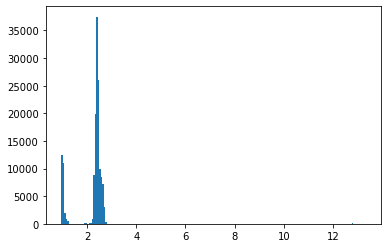

In [68]:
plt.hist(xyz_c[:,2], bins =200)
plt.show()

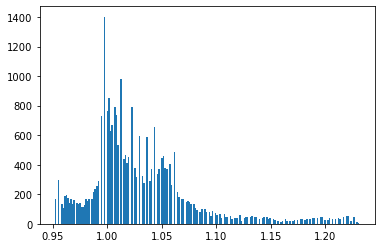

In [69]:
rgb_n=rgb_n[depth_filter]
xyz_c=xyz_c[depth_filter]
plt.hist(xyz_c[:,2], bins =200)
plt.show()

In [70]:
xyz_c=xyz_c-xyz_c.mean(axis=0)

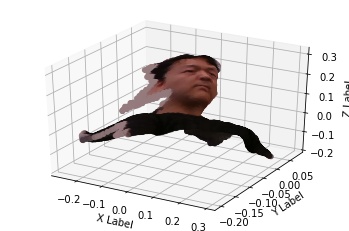

In [71]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z ixn [zlow, zhigh].

#ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=rgb/256)
ax.scatter(xyz_c[:,0], -xyz_c[:,2], -xyz_c[:,1], c=rgb_n)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [72]:
p = []
for i in range(xyz_c.shape[0]):
    next = vec(xyz_c[i,0],-xyz_c[i,1],-xyz_c[i,2])
    p.append({'pos':next, 'radius':0.003, 'color':(vec(rgb_n[i,0],rgb_n[i,1],rgb_n[i,2]))})
i


26778

In [73]:
print(np.min(xyz_c[:,0]),np.max(xyz_c[:,0]))
print(np.min(xyz_c[:,1]),np.max(xyz_c[:,1]))
                                     

-0.2599029974233537 0.29132400257664626
-0.2993627001381661 0.1775202998618339


In [ ]:

scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable
scene.width = scene.height = 600
scene.background = color.white
scene.range =0.4

run = False
def Runbutton(b):
    global run
    if b.text == 'Pause':
        run = False
        b.text = 'Run'
    else:
        run = True
        b.text = 'Pause'

 

        
button(text='Run', bind=Runbutton)

scene.append_to_caption("""<br>Right button drag or Ctrl-drag to rotate "camera" to view scene.
Middle button or Alt-drag to drag up or down to zoom in or out.
  On a two-button mouse, middle is left + right.
Touch screen: pinch/extend to zoom, swipe or two-finger rotate.""")

    
c = points(pos=p, size_units='world')
while True:
    rate(20)
    if run: # Currently there isn't a way to rotate a points object, so rotate scene.forward:
        scene.forward = scene.forward.rotate(angle=-0.005, axis=vec(0,1,0))

<IPython.core.display.Javascript object>